## test rd detection

In [12]:
import os, sys, io, random, subprocess, re
import string
import urllib
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',200)
import pylab as plt
import seaborn as sns
sns.set_context('poster')
from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from mtbdiff import utils, analysis

In [13]:
asm = utils.get_mtb_assembly_data()
refs = pd.read_csv('../mtbdiff/data/ref_genomes.csv')
#refs

In [ ]:
#utils.fetch_test_data('../test_genomes')

## run mtbdiff on ref lineages 

In [32]:
reload(utils)
names = analysis.run_genomes('../test_genomes', outpath='../test_results')
struct, snp =  utils.get_nucdiff_results('../test_results', names)
struct = utils.annotate_results(struct)
S = utils.get_summary(struct)

../test_genomes/GCA_001593225.1.fa GCA_001593225.1
../test_genomes/GCA_000195835.2.fa GCA_000195835.2
../test_genomes/GCA_000008585.1.fa GCA_000008585.1
../test_genomes/GCA_006385035.1.fa GCA_006385035.1
../test_genomes/GCA_002982215.1.fa GCA_002982215.1
../test_genomes/GCA_000009445.1.fa GCA_000009445.1
../test_genomes/GCA_000016925.1.fa GCA_000016925.1
../test_genomes/GCA_001941665.1.fa GCA_001941665.1
249


In [33]:
S

,start,end,Name,freq,length,RD,gene,region_type
914,3795057,3796412,deletion,8,1355,-,None,other
667,2784616,2785969,deletion,8,1353,-,None,other
531,2268724,2268725,duplication,8,1,-,"Rv2023A,Rv2024c",other
532,2268724,2268725,insertion,8,1,-,"Rv2023A,Rv2024c",other
122,742633,742634,insertion,8,1,-,None,other
...,...,...,...,...,...,...,...,...
740,3122405,3122406,tandem_duplication,2,1,-,None,other
715,3054810,3054891,collapsed_tandem_repeat,2,81,-,PE_PGRS47,PE/PPE
708,2996117,2996168,collapsed_tandem_repeat,2,51,-,Rv2680,other
328,1481669,1481670,inserted_gap,2,1,-,Rv1319c,other


In [34]:
struct['assembly'] = struct.label.apply(lambda x: x.split('.')[0],1)
struct = struct.merge(asm, left_on='assembly',right_on='Assembly_nover',how='left')

In [35]:
reload(utils)
rdmat = utils.RD_matrix(struct,columns=['species'])

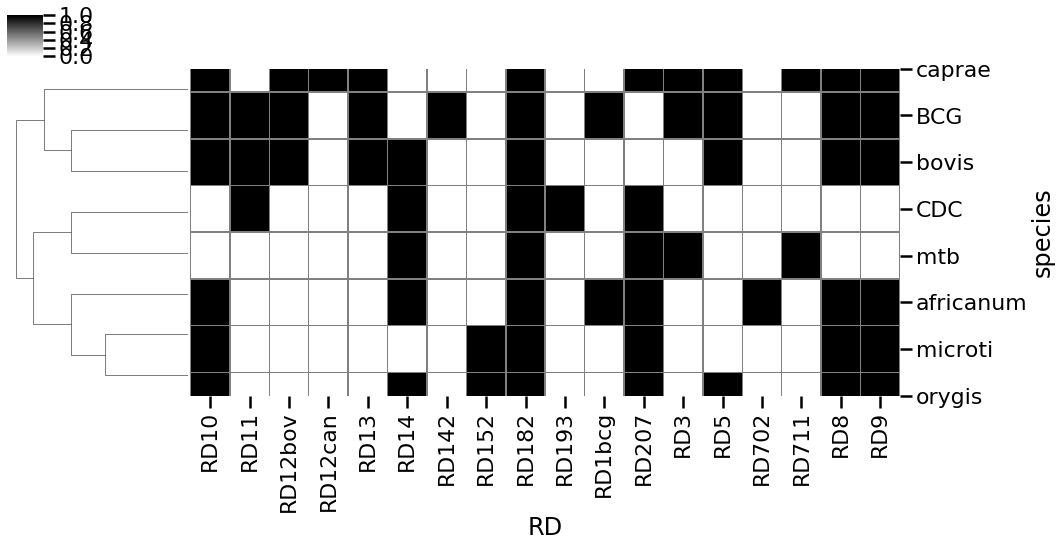

In [36]:
#x = rdmat.T.loc[:,rcols].fillna(0)
g = analysis.plot_RD(rdmat.T)
#g=sns.clustermap(rdmat.T,figsize=(18,6),linecolor='gray',cmap='gray_r',lw=0.5, xticklabels=True, col_cluster=False,
#                      yticklabels=True)
g.ax_cbar=None
g.savefig('RD_refs.png')

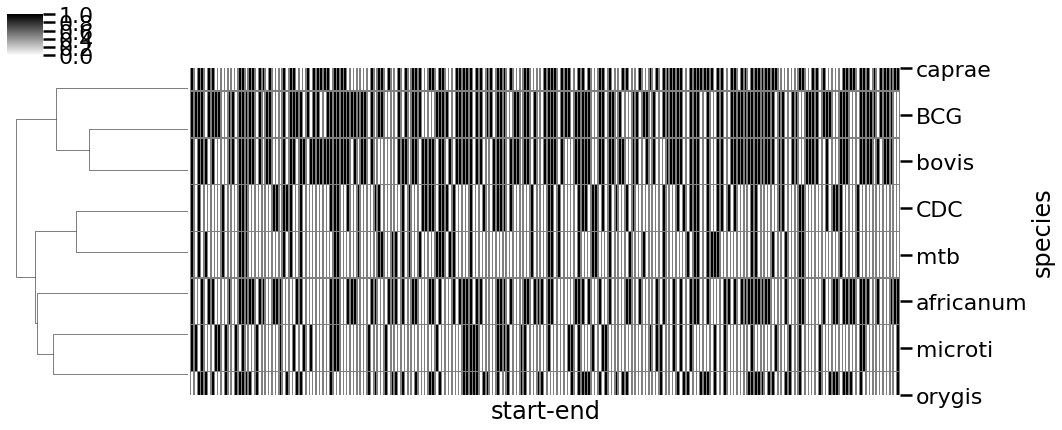

In [37]:
reload(utils)
reload(analysis)
smat = utils.sites_matrix(struct, columns=['species'], freq=1)
analysis.plot_RD(smat.T)

In [ ]:
RD = utils.RD
RD[:10]

## fix RD detection

remove false positives

In [47]:
def get_region(x, stcoord='start', endcoord='end'):
    """Get an overlapping RD from coord"""

    if x.Name != 'deletion':
        return '-'
    st = x[stcoord]; end = x[endcoord]
    found = RD[ (st>RD.Start) & (st<RD.Stop) |
                 ((end>RD.Start) & (end<RD.Stop)) |
                 ((st<RD.Start) & (end>RD.Stop))].copy()

    if len(found)>0:
        return found.iloc[0].RD_name
    else:
        return '-'

test = struct[struct.species=='BCG'].copy()
test['RD'] = test.apply(get_region,1)
subcols = ['label','ID','Name','start','end','length','descr','RD']
print (test[test.RD.isin(['RD12bov','RD1mic','RD1bcg'])][subcols])

               label      ID      Name    start      end  length                     descr       RD
716  GCA_000009445.1  SV_138  deletion  3484740  3487514    2774  deletion_3484740:3487514  RD12bov
786  GCA_000009445.1  SV_211  deletion  4350265  4359722    9457  deletion_4350265:4359722   RD1bcg


In [80]:
X = pd.pivot_table(struct,index=['RD'],columns=['species'],values='Name',aggfunc='count')
X

species,BCG,CDC,africanum,bovis,caprae,microti,mtb,orygis
RD,,,,,,,,
-,195.0,124.0,377.0,184.0,198.0,193.0,120.0,282.0
RD10,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0
RD11,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
RD12bov,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
RD12can,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
RD13,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
RD14,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0
RD142,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RD152,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0


## use decision matrix based on RD rules to attribute strain 

- simpler than classifer
- just apply the rules and compare to known assemblies

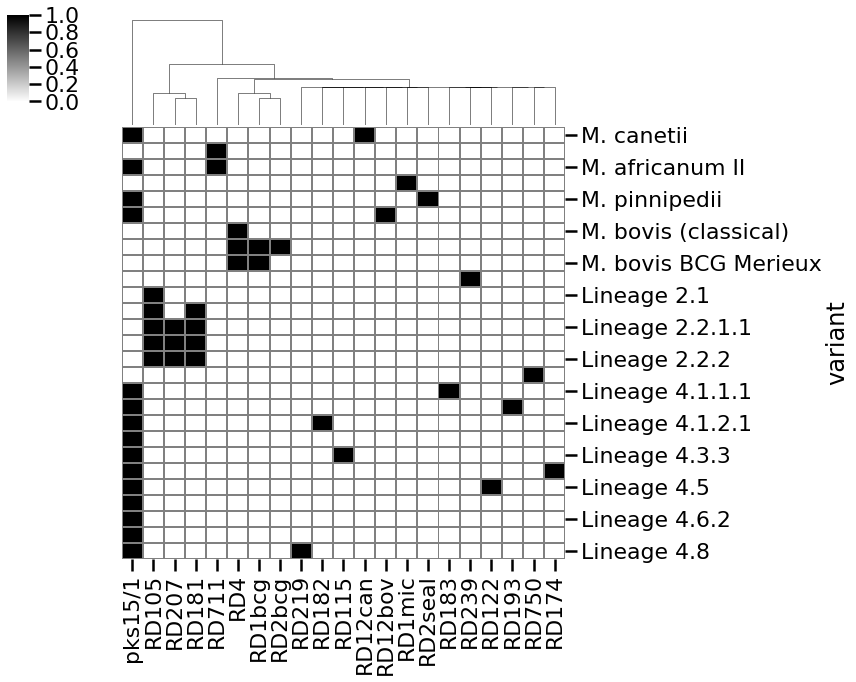

In [95]:
rulesmat = (pd.read_csv('../mtbdiff/data/RD_rules.csv')
            .set_index('variant').drop(columns=['rule','species']))
rcols = rulesmat.columns
#print (rulesmat)
sns.clustermap(rulesmat,cmap='gray_r',row_cluster=0,xticklabels=1,lw=1,linecolor='gray')

In [55]:
test = rdmat.T.loc[:,rcols].fillna(0)
print (test)
def get_id(value):
    for i, r in rulesmat.iterrows():
        print (i,r.values, x)
        if value is r.values:
            print ('ok')
x = test.iloc[0].values
print (x)
get_id(x)

           pks15/1  RD711  RD4  RD1bcg  RD1mic  RD2seal  RD2bcg  RD12bov  RD12can  RD105  ...  RD239  RD750  RD181  RD115  RD122  RD174  RD182  RD183  RD193  RD219
species                                                                                   ...                                                                      
BCG            0.0      0  0.0       1     0.0      0.0     0.0        1        0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0      1    0.0      0    0.0
CDC            0.0      0  0.0       0     0.0      0.0     0.0        0        0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0      1    0.0      1    0.0
africanum      0.0      0  0.0       1     0.0      0.0     0.0        0        0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0      1    0.0      0    0.0
bovis          0.0      0  0.0       0     0.0      0.0     0.0        1        0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0      1    0.0      0    0.0
caprae         0

In [ ]:
from wordcloud import WordCloud, STOPWORDS
text = '\n'.join(bioproj.Project_Title.astype(str))
wordcloud = WordCloud(
    width = 2500,
    height = 1000,
    background_color = 'gray',
    min_font_size=10,
    max_font_size=220,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (15,15),
    facecolor = 'w',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")